## Imports and stting functions

In [83]:
# @title Imports
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import time

In [84]:
# @title Data Loader
print("Loading Data...")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_data = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
x_train = train_data.data
image_size = x_train.shape[1] * x_train.shape[2]
x_train = x_train.reshape(-1, image_size).float() / 255

Loading Data...


In [85]:
# @title AutoEncoder
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(image_size, 256), nn.ReLU(),
            nn.Linear(256, 64), nn.ReLU(),
            nn.Linear(64, 32)
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64), nn.ReLU(),
            nn.Linear(64, 128), nn.ReLU(),
            nn.Linear(128, image_size), nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [86]:
#init autoencoder
autoencoder = Autoencoder()

## oracle functions
you should use to given model, loss function and x returns either the model output, the loss, the gradient and the hessian.

In [87]:
def autoencoder_oracle(model, criterion, x, calc_hessian=False):
    """
    Computes f(x), gradient, and Hessian for a given input x.
    """
    # Forward Pass
    reconstructed_x = model(x)
    loss = criterion(reconstructed_x, x)

    grads = torch.autograd.grad(loss, model.parameters(), create_graph=calc_hessian)

    hessians = []

    if calc_hessian:
        for i, (grad, param) in enumerate(zip(grads, model.parameters())):

            grad_flat = grad.view(-1)

            hessian_rows = []
            for j in range(len(grad_flat)):
                grad_2nd = torch.autograd.grad(grad_flat[j], param, retain_graph=True)[0]
                hessian_rows.append(grad_2nd.view(-1))

            hessian_matrix = torch.stack(hessian_rows)
            hessians.append(hessian_matrix)

    return loss, grads, hessians

In [88]:
print("Initializing the model (Defining the function surface)...")
train_dataset = TensorDataset(x_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# This dataset is for the second order learners - so you wont run out of RAM
small_train_dataset = TensorDataset(x_train[:100])  # רק 100 תמונות להדגמה
small_train_loader = DataLoader(small_train_dataset, batch_size=10, shuffle=True)



Initializing the model (Defining the function surface)...


## Examples for optimizers

In [89]:
def gd_step(x, grad_f_x, learning_rate=0.1):
    """
    Performs one step of Gradient Descent.
    Formula: x_new = x - lr * gradient
    """
    x_new = x - learning_rate * grad_f_x

    return x_new

In [90]:
def newton_step(x, grad_f_x, hessian_f_x, learning_rate=1.0):
    """
    Performs one step of Newton-Raphson optimization on a batch.
    Shapes:
      x: (Batch, Dim)
      grad_f_x: (Batch, Dim)
      hessian_f_x: (Batch, Dim, Dim)
    """
    # 1. Calculate Inverse Hessian
    # torch.linalg.pinv handles batch dimensions automatically (Batch, D, D)
    hessian_inv = torch.linalg.pinv(hessian_f_x)

    # 2. Prepare Gradient for Batch Matrix Multiplication
    # grad_f_x is (Batch, D). We need (Batch, D, 1) for matmul
    grad_unsqueezed = grad_f_x.unsqueeze(2)

    # 3. Compute Update Direction: H^-1 * Gradient
    # (Batch, D, D) x (Batch, D, 1) -> (Batch, D, 1)
    update_direction = torch.matmul(hessian_inv, grad_unsqueezed)

    # 4. Remove extra dimension: (Batch, D, 1) -> (Batch, D)
    update_direction = update_direction.squeeze(2)

    # 5. Apply Update
    x_new = x - learning_rate * update_direction

    return x_new

## Our models

In [155]:
import math

class AdamWState:
    """
    Minimal state container for AdamW, using article notation:
    alpha (α), beta1 (β1), beta2 (β2), epsilon (ε), lambda_ (λ), eta_t (η_t).
    """

    def __init__(self, param, alpha=1e-3, beta1=0.9, beta2=0.999,
                 epsilon=1e-8, lambda_weight_decay=0.05):
        self.alpha = alpha  # α
        self.beta1 = beta1  # β1
        self.beta2 = beta2  # β2
        self.epsilon = epsilon  # ε
        self.lambda_ = lambda_weight_decay  # λ

        # Global step
        self.t = 0

        # Per-parameter first and second moments: m_t, v_t
        self.m = torch.zeros_like(param)
        self.v = torch.zeros_like(param)

    def eta_t(self):
        """
        η_t schedule multiplier (SetScheduleMultiplier(t) in the paper).
        For now: constant 1.0 (we can later plug in cosine annealing, etc.).
        """
        return 1.0


def adamw_step(param_data, grad, state: AdamWState):
    """
    Single AdamW update step, using the gradient tensors from the oracle.
    Implements Algorithm 2 (Adam with decoupled weight decay, AdamW). [file:2]

    θ_t = θ_{t-1} - η_t * ( α * m_hat_t / (sqrt(v_hat_t) + ε) + λ * θ_{t-1} )
    """
    state.t += 1
    t = state.t
    beta1, beta2 = state.beta1, state.beta2
    alpha = state.alpha
    eps = state.epsilon
    lam = state.lambda_
    eta_t = state.eta_t()

    # m_t = β1 m_{t-1} + (1-β1) g_t
    state.m.mul_(beta1).add_(grad, alpha=(1.0 - beta1))

    # v_t = β2 v_{t-1} + (1-β2) g_t^2
    state.v.mul_(beta2).addcmul_(grad, grad, value=(1.0 - beta2))

    # Bias correction
    bias_correction1 = 1.0 - beta1 ** t
    bias_correction2 = 1.0 - beta2 ** t
    m_hat = state.m / bias_correction1
    v_hat = state.v / bias_correction2

    # Adam direction (loss-driven part)
    adam_direction = m_hat / (v_hat.sqrt() + eps)

    # θ_t = θ_{t-1} - η_t * ( α * adam_direction + λ * θ_{t-1} )
    update = alpha * adam_direction + lam * param_data
    return param_data - eta_t * update


def rms(tensor: torch.Tensor):
    return tensor.pow(2).mean().sqrt()


class AdafactorState:
    """
    Minimal state container for Adafactor (Algorithms 4 & 5). [file:1]

    Uses:
    - ρ_t schedule (relative step-size multiplier)
    - β2_t schedule (second-moment decay)
    - ε1, ε2, d as in the paper
    """

    def __init__(self, param,
                 epsilon1=1e-30, epsilon2=1e-3,
                 d=1.0,
                 beta2_exponent=0.8):
        # Small constants
        self.epsilon1 = epsilon1  # ε1 (for second-moment denom)
        self.epsilon2 = epsilon2  # ε2 (for RMS lower bound)
        self.d = d  # clipping threshold

        # Schedules for β2_t, ρ_t; we use the paper's proposal: β2_t = 1 - t^{-c}. [file:1]
        self.beta2_exponent = beta2_exponent

        self.t = 0

        # Factored second-moment states per parameter:
        # For matrices: R_t (rows), C_t (cols)
        # For vectors: V_t
        if param.ndim == 2:
            n, m = param.shape
            self.is_matrix = True
            self.R = torch.zeros(n, device=param.device, dtype=param.dtype)
            self.C = torch.zeros(m, device=param.device, dtype=param.dtype)
            self.V = None
        else:
            self.is_matrix = False
            self.R = None
            self.C = None
            self.V = torch.zeros_like(param)

    def beta2_t(self):
        """
        β2_t schedule, as in section 7.2: β2_t = 1 - t^{-c}, with c = beta2_exponent. [file:1]
        Ensures β2_1 = 0, increasing towards 1.
        """
        t = max(self.t, 1)
        c = self.beta2_exponent
        return 1.0 - t ** (-c)

    def rho_t(self):
        """
        ρ_t (relative step-size scalar). Paper suggests schedules like:
        ρ_t = min(lr_scale / sqrt(t), lr_scale / t). [file:1]

        For now, use a simple schedule; we can tune it:
        ρ_t = min(1e-2, 1.0 / sqrt(t))
        """
        t = max(self.t, 1)
        return min(1e-2, 1.0 / math.sqrt(t))


def adafactor_step(param_data, grad, state: AdafactorState):
    """
    Single Adafactor update for all parameters, using oracle gradients. [file:1]

    For each parameter X:
      1. α_t = max(ε2, RMS(X_{t-1})) * ρ_t
      2. Update second-moment estimates (factored for matrices, vector V_t for 1D)
      3. U_t = G_t / sqrt(V_t + ε1)
      4. Clip U_t by RMS if needed
      5. X_t = X_{t-1} - α_t * U_t
      
    Per-parameter Adafactor update. Returns updated param_data.
    """
    state.t += 1
    beta2_t = state.beta2_t()
    rho_t = state.rho_t()
    eps1 = state.epsilon1
    eps2 = state.epsilon2
    d = state.d

    # Step-size scale from parameter RMS
    rms_x = max(eps2, param_data.pow(2).mean().sqrt().item())
    alpha_t = rms_x * rho_t  # α_t = max(ε2, RMS(X_{t-1})) * ρ_t
    
    G = grad
    
    # Row and column means of squared gradients
    grad_sq = G.pow(2)

    if state.is_matrix:
        # Matrix case, Algorithm 4. [file:1]

        # Row means: (n,)
        row_mean = grad_sq.mean(dim=1)
        # Column means: (m,)
        col_mean = grad_sq.mean(dim=0)

        # R_t update
        state.R.mul_(beta2_t).add_(row_mean, alpha=(1.0 - beta2_t))
        # C_t update
        state.C.mul_(beta2_t).add_(col_mean, alpha=(1.0 - beta2_t))

        # Reconstruct V_t: outer product, normalized by mean(R_t). [file:1]
        R_t = state.R
        C_t = state.C
        # Outer product (n x m)
        V_t = torch.ger(R_t, C_t)  # R_t[:, None] * C_t[None, :]
        denom = R_t.mean()
        if denom > 0:
            V_t = V_t / denom
        else:
            V_t = V_t + eps1  # safeguard

    else:
        # Vector or fallback case, Algorithm 5. [file:1]
        
        # Use mean over all elements
        mean_grad_sq = grad_sq.mean()
        state.V.mul_(beta2_t).add_(mean_grad_sq, alpha=(1.0 - beta2_t))
        V_t = state.V.expand_as(G)

    # Unscaled update
    U_t = G / (V_t.sqrt() + eps1)

    # Update clipping by RMS(U_t)
    rms_u = U_t.pow(2).mean().sqrt().item()
    clip_denom = max(1.0, rms_u / d)
    U_t = U_t / clip_denom

    return param_data - alpha_t * U_t

# -------------------------
# Cosine schedule with warm restarts (AdamWR-style, to be used for Adafactor++)
# -------------------------

class CosineWarmRestartSchedule:
    """
    Cosine multiplier η_t with warm restarts, as in SGDR/AdamWR. [file:2]

    Tracks:
    - T_i: current cycle length (in "epochs" or effective units you choose)
    - T_cur: progress inside current cycle
    You can call .step(delta) each epoch (or every k steps) to advance T_cur.
    """

    def __init__(self, Ti_initial=5.0, T_mult=2.0, eta_min=0.0, eta_max=1.0):
        self.Ti = Ti_initial      # current cycle length
        self.T_mult = T_mult
        self.eta_min = eta_min
        self.eta_max = eta_max
        self.T_cur = 0.0

    def step_epoch(self, delta_epochs=1.0):
        """
        Call this once per epoch (or scaled appropriately) to advance the schedule.
        """
        self.T_cur += delta_epochs
        if self.T_cur >= self.Ti:
            # restart
            self.T_cur = 0.0
            self.Ti *= self.T_mult

    def eta_t(self):
        """
        Cosine multiplier in [eta_min, eta_max]. [file:2]
        """
        cos_inner = math.pi * self.T_cur / self.Ti
        cos_val = math.cos(cos_inner)
        # return self.eta_min + 0.5 * (self.eta_max - self.eta_min) * (1.0 + cos_val)
        return 1


# -------------------------
# Adafactor-W-WR per-parameter state
# -------------------------

class AdafactorWWRState:
    """
    Per-parameter state for improved Adafactor:
    - Factored second moments (R, C) for matrices; V for vectors. [file:1]
    - Decoupled weight decay (λ). [file:2]
    - Relative step size with RMS scaling. [file:1]
    """
    def __init__(self, param,
                 epsilon1=1e-30, epsilon2=1e-3,
                 d=1.0, beta2_exponent=0.8,
                 rho_max=1e-2,
                 lambda_norm=0.0,
                 batch_size=None, dataset_size=None, total_epochs=None,
                 schedule: CosineWarmRestartSchedule = None):
        self.epsilon1 = epsilon1   # ε1
        self.epsilon2 = epsilon2   # ε2
        self.d = d                # clipping threshold
        self.beta2_exponent = beta2_exponent  # c in β2_t = 1 - t^{-c} [file:1]
        self.rho_max = rho_max    # cap for ρ_t
        self.t = 0

        # Factored second-moment storage
        if param.ndim == 2:
            n, m = param.shape
            self.is_matrix = True
            self.R = torch.zeros(n, device=param.device, dtype=param.dtype)
            self.C = torch.zeros(m, device=param.device, dtype=param.dtype)
            self.V = None
        else:
            self.is_matrix = False
            self.R = None
            self.C = None
            self.V = torch.zeros_like(param)

        # Cosine warm restart schedule (shared or per-param)
        self.schedule = schedule if schedule is not None else CosineWarmRestartSchedule()

        # Normalized weight decay λ from λ_norm. [file:2]
        if lambda_norm > 0.0 and batch_size is not None and dataset_size is not None and total_epochs is not None:
            self.lambda_ = lambda_norm * (batch_size / (dataset_size * total_epochs))
        else:
            self.lambda_ = 0.0

    def beta2_t(self):
        t = max(self.t, 1)
        c = self.beta2_exponent
        return 1.0 - t ** (-c)

    def rho_t(self):
        t = max(self.t, 1)
        return min(self.rho_max, 1.0 / math.sqrt(t))

    def eta_t(self):
        # Cosine multiplier η_t. [file:2]
        return self.schedule.eta_t()

# -------------------------
# Adafactor-W-WR per-parameter step
# -------------------------

def adafactor_wwr_step(param_data, grad, state: AdafactorWWRState):
    """
    Per-parameter Adafactor with:
    - factored second moments & relative step size (Adafactor) [file:1]
    - decoupled normalized weight decay (AdamW) [file:2]
    - cosine warm restarts multiplier (AdamWR) [file:2]

    Returns updated param_data.
    """
    state.t += 1
    beta2_t = state.beta2_t()
    rho_t = state.rho_t()
    eps1 = state.epsilon1
    eps2 = state.epsilon2
    d = state.d
    lam = state.lambda_
    
    # advance the schedule multipiler
    state.schedule.step_epoch(1.0)
    
    # set the current eta
    eta_t = state.eta_t()
    
    # α_t = η_t * max(ε2, RMS(X_t)) * ρ_t
    rms_x = max(eps2, param_data.pow(2).mean().sqrt().item())
    alpha_t = eta_t * rms_x * rho_t

    G = grad
    grad_sq = G.pow(2)

    # --- update second-moment stats (factored or vector) ---
    if state.is_matrix:
        # Matrix case: row/column stats [file:1]
        row_mean = grad_sq.mean(dim=1)  # (n,)
        col_mean = grad_sq.mean(dim=0)  # (m,)

        state.R.mul_(beta2_t).add_(row_mean, alpha=(1.0 - beta2_t))
        state.C.mul_(beta2_t).add_(col_mean, alpha=(1.0 - beta2_t))

        R_t = state.R
        C_t = state.C
        V_t = torch.ger(R_t, C_t)
        denom = R_t.mean()
        if denom > 0:
            V_t = V_t / denom
        else:
            V_t = V_t + eps1
    else:
        # Vector / fallback: single V_t [file:1]
        mean_grad_sq = grad_sq.mean()
        state.V.mul_(beta2_t).add_(mean_grad_sq, alpha=(1.0 - beta2_t))
        V_t = state.V.expand_as(G)

    # --- adaptive direction ---
    U_t = G / (V_t.sqrt() + eps1)

    # Update clipping
    rms_u = U_t.pow(2).mean().sqrt().item()
    clip_denom = max(1.0, rms_u / d)
    U_t = U_t / clip_denom

    # --- decoupled weight decay (AdamW-style) ---
    if lam != 0.0:
        param_data = param_data - alpha_t * lam * param_data

    # --- final Adafactor update ---
    param_data = param_data - alpha_t * U_t

    return param_data


In [158]:
def run_model_optimization_experiment(
        optimizer_type: str,
        model: nn.Module,
        criterion: nn.Module,
        train_loader: DataLoader,
        epochs: int,
        learning_rate: float
):
    """
    Runs an optimization experiment to train the MODEL using GD or Newton.
    Closer to the requested structure.
    """
    all_losses = []
    print(f"\nStarting MODEL {optimizer_type.upper()} optimization for {epochs} epochs (lr={learning_rate})...")
    total_start_time = time.time()

    for epoch in range(epochs):
        epoch_loss = 0

        for batch_idx, batch in enumerate(train_loader):
            img = batch[0]

            calc_hessian_for_oracle = (optimizer_type == 'newton')
            loss, grads, hessians = autoencoder_oracle(model, criterion, img, calc_hessian=calc_hessian_for_oracle)

            epoch_loss += loss.item()

            # 2. Optimization step
            with torch.no_grad():
                if optimizer_type == 'gd':
                    for param, grad in zip(model.parameters(), grads):
                        param.data = gd_step(param.data, grad, learning_rate)

                elif optimizer_type == 'newton':
                    if hessians is None:
                        raise ValueError("Hessian missing for Newton method")
                    for param, grad, hessian in zip(model.parameters(), grads, hessians):
                        param.data = newton_step(param.data, grad, hessian, learning_rate)

                elif optimizer_type == 'adamw':
                    for (param, grad, state) in zip(model.parameters(), grads, adamw_states):
                        param.data = adamw_step(param.data, grad, state)

                elif optimizer_type == 'adafactor':
                    for (param, grad, state) in zip(model.parameters(), grads, adafactor_states):
                        param.data = adafactor_step(param.data, grad, state)
                
                elif optimizer_type == 'adafactor_wwr':
                    for (param, grad, state) in zip(model.parameters(), grads, adafactor_wwr_states):
                        param.data = adafactor_wwr_step(param.data, grad, state)

                else:
                    raise ValueError("Invalid optimizer type")

        avg_loss = epoch_loss / len(train_loader)
        all_losses.append(avg_loss)

        if (epoch + 1) % (epochs // 5) == 0 or epoch == 0 or epoch == epochs - 1:
            print(f"  Epoch [{epoch + 1}/{epochs}] Loss: {avg_loss:.6f}")

    total_end_time = time.time()
    total_training_time = total_end_time - total_start_time
    print(f"\nTotal Training Time: {total_training_time:.2f} seconds")
    print(f"Finished {optimizer_type.upper()} optimization. Final Loss: {all_losses[-1]:.6f}")
    return model, all_losses

In [159]:
epochs = 100
lr = 0.01
model = Autoencoder()
criterion = nn.MSELoss()

# Storing the hyperparameters in a dedicated state of each algorithm
adamw_states = [
    AdamWState(p.data, alpha=lr, beta1=0.9, beta2=0.999,
               epsilon=1e-8, lambda_weight_decay=0.01)
    for p in model.parameters()
]

adafactor_states = [
    AdafactorState(p.data,
                   epsilon1=1e-30, epsilon2=1e-3,
                   d=1.0, beta2_exponent=0.8)
    for p in model.parameters()
]

shared_schedule = CosineWarmRestartSchedule(Ti_initial=5.0, T_mult=3.0)

adafactor_wwr_states = [
    AdafactorWWRState(
        p.data,
        epsilon1=1e-30,
        epsilon2=1e-3,
        d=1.0,
        beta2_exponent=0.8,
        rho_max=1e-2,
        lambda_norm=3e-2,
        batch_size=train_loader.batch_size,
        dataset_size=len(train_loader.dataset),
        total_epochs=epochs,
        schedule=shared_schedule
    )
    for p in model.parameters()
]


trained_model, losses = run_model_optimization_experiment(
    'adafactor_wwr', model, criterion, train_loader, epochs, lr
)


Starting MODEL ADAFACTOR_WWR optimization for 100 epochs (lr=0.01)...
  Epoch [1/100] Loss: 0.041892
  Epoch [20/100] Loss: 0.011935
  Epoch [40/100] Loss: 0.010113
  Epoch [60/100] Loss: 0.009342
  Epoch [80/100] Loss: 0.008920
  Epoch [100/100] Loss: 0.008643

Total Training Time: 522.73 seconds
Finished ADAFACTOR_WWR optimization. Final Loss: 0.008643


### Loss Curves Over Epochs

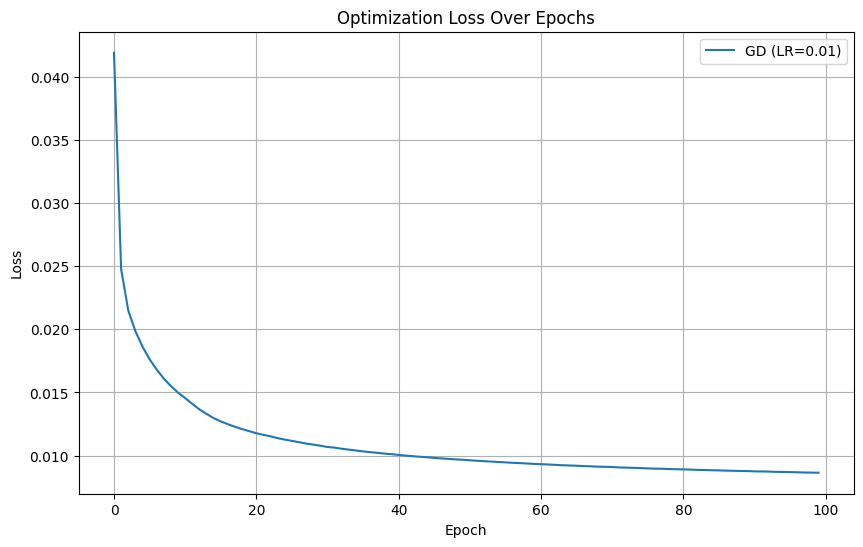

In [160]:
plt.figure(figsize=(10, 6))
plt.plot(losses, label=f'GD (LR={lr})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Optimization Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


### Visual Comparison of Optimized Images


Visualizing Results...


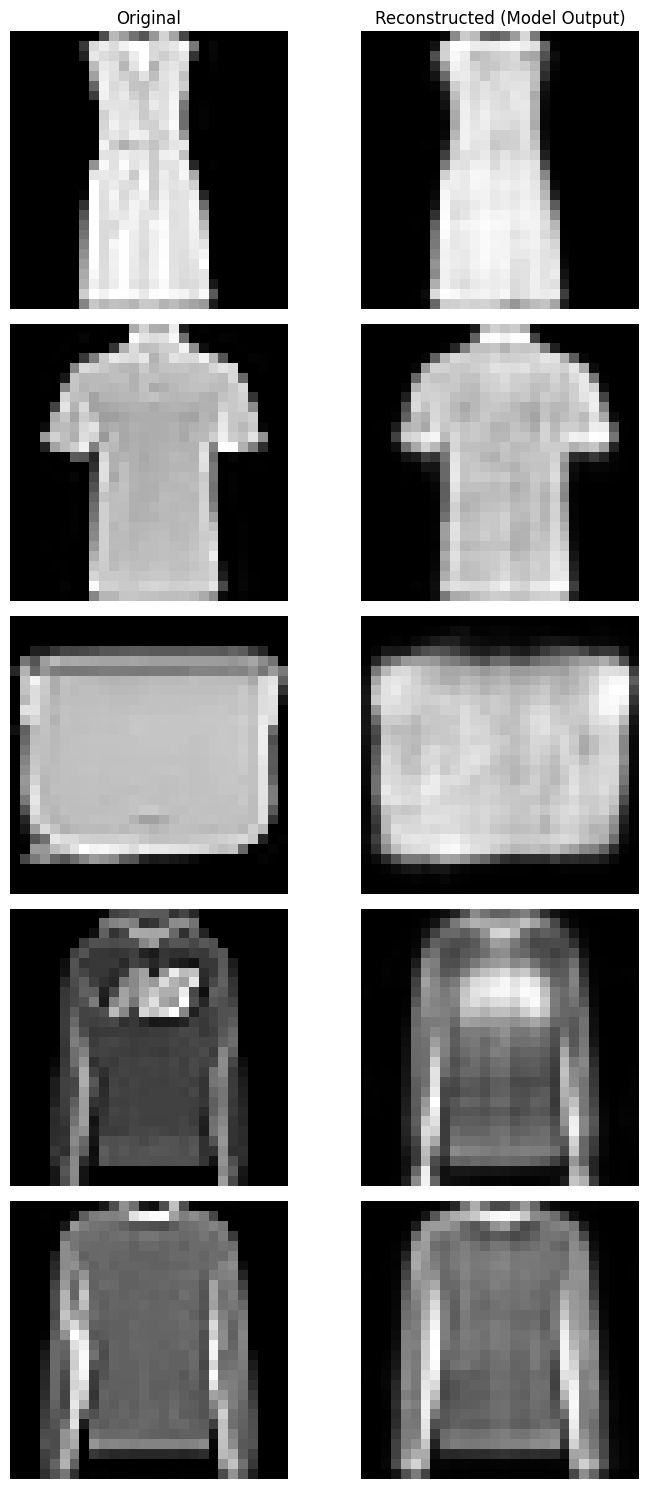

In [161]:
def show_model_reconstructions(model, batch_images, count=5):
    """
    Visualizes original images vs. model reconstructions.
    """
    print("\nVisualizing Results...")

    model.eval()

    with torch.no_grad():
        inputs = batch_images[:count]
        reconstructions = model(inputs)

    plt.figure(figsize=(8, 3 * count))

    for i in range(count):
        img_orig = inputs[i].cpu().numpy().reshape(28, 28)
        img_recon = reconstructions[i].cpu().numpy().reshape(28, 28)

        # Original
        ax = plt.subplot(count, 2, i * 2 + 1)
        plt.imshow(img_orig, cmap='gray')
        if i == 0: ax.set_title("Original")
        plt.axis('off')

        #Reconstructed
        ax = plt.subplot(count, 2, i * 2 + 2)
        plt.imshow(img_recon, cmap='gray')
        if i == 0: ax.set_title("Reconstructed (Model Output)")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


# ---use example ---
data_iter = iter(train_loader)
sample_images = next(data_iter)[0]

show_model_reconstructions(trained_model, sample_images, count=5)